In [97]:
import numpy as np
import random
from geneticalgorithm import geneticalgorithm as ga
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%matplotlib inline

In [98]:
# Set Variables
mean_demand = 100  # average daily demand
demand_std = 20    # daily deviation
max_lead_time = 21 # in days
min_lead_time = 5  # in days
service_level = 95 # as percent

simulation_rounds = 10
simulation_length = 250 # in days

In [99]:
# Demand Generator using a normal distribution

def generate_daily_demand(daily_mean, daily_std):
    
    daily_demand = round(np.random.normal(daily_mean, daily_std),0)
    
    return daily_demand



In [100]:
# Runs a single day of operations including:
# * Receiving Orders
# * Using Parts
# * Returns ending inventory, daily usage

def run_daily_operations(beg_inventory, to_be_received):
    
    inventory = beg_inventory
    
    # Receive Stock
    inventory += to_be_received
    
    # Use parts
    demand = generate_daily_demand(mean_demand, demand_std)
    inventory -= demand
    
    return [inventory, demand]

In [131]:
# Build the simulation
# We will use 2 inputs (X)
# * Order Point
# * Order Quantity

def inventory_simulation(X):
    order_point = X[0]
    order_quantity = X[1]
    
    average_inventory = 0
    average_service_level = 0
    
    for sim_round in range(simulation_rounds):
        
        round_average_inventory = 0
        round_service_level = 0
        
        # Set Counters (all averages of simulation rounds)
        stockout_quantity = 0
        orders = 0
        usage = 0
        
        # Set Tracking Dictionaries
        day_idx = list(range(1,simulation_length+1))
        on_order = {day:0 for day in day_idx}
        
        # Set tracking arrays
        demand_tracking = []
        inventory_tracking = []
        units_sold_tracking = []
        
        # Set starting numbers
        inventory = order_quantity
        
        for day in range(simulation_length+1):
   
            if day == 0:
                pipeline_inventory = 0
                inventory = order_quantity
            else:
                beginning_inventory = inventory
            
                # calculate leadtime, so we have it if needed
                leadtime = random.randint(min_lead_time,max_lead_time)

                # check to see if we need to reorder after yesterday activities 
                if (inventory + pipeline_inventory) <= order_point:
                    on_order[day+leadtime] = order_quantity

                daily_operations = run_daily_operations(inventory,on_order[day])
                
                inventory = max(daily_operations[0],0)
                inventory_tracking.append(inventory)
                demand_tracking.append(daily_operations[1])
                units_sold_tracking.append(min(daily_operations[1],inventory))
                
                pipeline_inventory = 0

                for order_day, quantity in on_order.items():
                    if order_day >= day+1: pipeline_inventory += quantity
         
        # Calculations for this simulation round
        round_average_inventory += np.mean(inventory_tracking)             #accumulating
        round_unit_sales = np.sum(units_sold_tracking)
        round_total_demand = np.sum(demand_tracking)
        
        round_service_level += (round_unit_sales / round_total_demand)*100 #accumulating
        
        print(round_average_inventory)
        print(round_unit_sales)
        print(round_total_demand)
    
    # Calculations based on all simulations
    average_inventory = round_average_inventory / simulation_rounds
    average_service_level = round_service_level / simulation_rounds
    
    # Objective Function calculation
    penalty = 0#5*max_lead_time*generate_daily_demand(mean_demand, demand_std) # max possible value
    
    if average_service_level < service_level:
        objective_function = average_inventory + penalty
    else:
        objective_function = average_inventory
    
    return [objective_function, average_service_level]

In [132]:
# Average Inventory
inventory_simulation([500,1000])

216.528
10816.0
24949.0
255.808
12479.0
24706.0
279.708
13414.0
24627.0
247.424
11916.0
25110.0
247.164
12005.0
24487.0
235.112
11689.0
25408.0
253.364
12530.0
25274.0
254.82
12626.0
24768.0
255.556
12537.0
24930.0
254.268
12489.0
25392.0


[25.4268, 4.918478260869565]

In [68]:
# Set variable bounds
varbound = np.array([[0,mean_demand*simulation_length]]*2)

In [63]:
# Set the algorithm parameters
algorithm_param = {'max_num_iteration': 1000,
                   'population_size':15,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'max_iteration_without_improv':100}

In [64]:
# Objective Function: average inventory
# Goal:               Minimize our objective function
# Contraints:         Maintain Service Level

# Build the model
model=ga(function=inventory_simulation,dimension=2,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)


 The best solution found:                                                                           
 [ 363.70883565 2427.20220539]

 Objective function:
 508.20320143460975


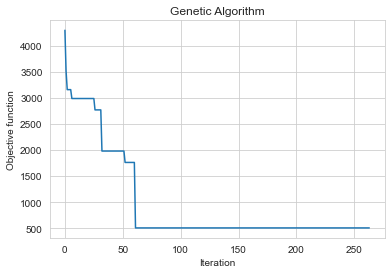

In [65]:
model.run()

Improvement
* use better distributions
* use compound distributions (Poisson for timing, lognormal for quantity)
* Dont use average rounds (lose data), or find a way to capture
* Incorporate order costs, storage costs, and other costs
* Auto load historical data to generate the optimiziation
